# Exploring the economic recovery whole user journey subgraph

This approach does not rely on the existing knowledge graph. It uses a functional graph based on page hit session data, to find a list of pages related to the economic recovery whole user journey (WUJ).

ASSUMPTIONS: 
- A set of pre-defined pages have been removed from the economic recovery WUJ subgraph
- Any pages with a shortest page path length equal to or greater than 3 from both `seed0` pages are removed from the economic recovery WUJ subgraph

OUTPUT: 
- A csv containing a list of pages related to the economic recovery WUJ. Sorted in descending order. 

REQUIREMENTS: 
- Run `step_one_identify_seed_pages.ipynb` to define `seed0` and `seed1` pages
- Run `step_two_extract_page_hits.sql` to extract page hits for sessions that visit at least one `seed0` or `seed1` page
- Run `step_three_extract_nodes_and_edges.sql` to extract nodes and edges 
- Run `step_four_create_networkx_graph.ipynb` to create NetworkX graph of the economic recovery whole user journey. 

## Import statements  

In [5]:
from neo4j import GraphDatabase
import networkx as nx
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import operator
from operator import itemgetter
from collections import defaultdict
import gspread 
from oauth2client.service_account import ServiceAccountCredentials
from collections import Counter

## Functions for coercing knowledge graph into NetworkX

In [6]:
def getSubgraph(q, parameters=None):

    '''
    Given a Cypher query q, this function queries the knowledge graph,
    returns the nodes and edges from this query, and uses them to construct
    a networkx graph.

    E.g. getSubgraph(r'MATCH (u:Cid)-[r:HYPERLINKS_TO]->(v:Cid) RETURN *')
         returns the structural graph.

    Optionally, can add in parameters (dictionary), allowing Python variables
    to be integrated into the Cypher query q.

    E.g.
        parameters = {}
        parameters['pages'] = ['a','list','of','stuff']
        q7 = f"""
        MATCH (u:Cid)-[r]-(v:Cid)
        WHERE u.name IN $pages AND v.name in $pages
        RETURN *
        """

        g7 = getSubgraph(q7, parameters)
    '''

    # get credentials
    # add to .secrets: export KG_PWD="<PASSWORD>"
    KG_PWD = os.getenv("KG_PWD")

    # create connection to knowledge graph
    driver = GraphDatabase.driver(
        "bolt+s://knowledge-graph.integration.govuk.digital:7687",
        auth=("neo4j", KG_PWD),
    )

    # run query on knowledge graph
    results = driver.session().run(q, parameters)

    # create networkx graph object
    G = nx.MultiDiGraph()

    # add nodes into networkx graph object
    nodes = list(results.graph()._nodes.values())
    print("Adding nodes\n")
    for node in tqdm(nodes):
        G.add_node(node.id, labels=node._labels, properties=node._properties)

    # add edges into networkx graph object
    rels = list(results.graph()._relationships.values())
    print("Adding edges\n")
    for rel in tqdm(rels):
        G.add_edge(
            rel.start_node.id,
            rel.end_node.id,
            key=rel.id,
            type=rel.type,
            properties=rel._properties,
        )

    return G


def showGraph(g):
    """
    Given a networkx graph g, this function visualises the graph.
    Do not use for a large g.
    """
    print(nx.info(g))
    nx.draw(g)

In [7]:
def getNoOfTruePages(g):
    """
    Calculate a proxy recall metric for the list of pages identified in a
    subgraph (when compared to the ground truth for the economic recovery pages). 
    The output is the number of pages in the subgraph list that are present in 
    the ground truth list.  
    """
    
    # convert nodeIds to page path slug for the subgraph list
    subgraph_list = [node[0] for node in g.nodes(data=True)]

    # set up the ground truth list
    true_list = list(economic_pages)

    # how many pages are in the subgraph list that are also in the ground truth list
    return (len(true_list)) - (len([node for node in true_list if node not in subgraph_list]))

In [8]:
def getPagesNotInSubGraph(g):
    """
    Return a set of pages which are in the economic recovery pre-defined list
    (41 in total), but are not in the filtered subgraph list. 
    """
    
    # list of pages manually defined in the economic recovery whole user journey 
    true_list = list(economic_pages)
    
    # list of pages in the filtered subgraph list
    subgraph_list = [node[0] for node in g.nodes(data=True)]
    
    # the list of pages in the manually defined list not in the subgraph list
    return [node for node in true_list if node not in subgraph_list]

## Pre-defined economic recovery subgraph

The pages (nodes) in the manually defined list for economic recovery (41 pages in total)

In [ ]:
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

# Connect to service account
scope = ['https://spreadsheets.google.com/feeds'] 
credentials = ServiceAccountCredentials.from_json_keyfile_name(GOOGLE_APPLICATION_CREDENTIALS, scope) 
gc = gspread.authorize(credentials)

# Import the data from google sheets
spreadsheet_key = '1lLsgQRsl4bXmbyiwrbMNQOR_Zu-FkbqYRUmOOhTYc70' 
book = gc.open_by_key(spreadsheet_key) 
worksheet = book.worksheet('Top pages') 
table = worksheet.get_all_values()

# Convert table data into a dataframe then set 
df = pd.DataFrame(table[1:], columns=table[0])
economic_pages=set(list(filter(None, df['pagePathv2'])))

## Exploring the economic recovery functional network

- 11677 nodes and 88111 edges
- The page `/guidance/international-trade-products-and-schemes` which is in the manually defined graph, is **not** in this subgraph. This seems to be an old page (updated 2013) related to exporting agricultural products to the EU
- The distribution of session hit data demonstrates that only 25% of the page paths have session hits over 8. The maximum number of session hit for a page path is 71667: 
    - Min: 1
    - Max: 71667
    - 25th percentile: 1
    - 50th percentile: 2
    - 75th percentile: 8


In [346]:
# import the NetworkX graph object
g = nx.read_gpickle("../../data/processed/functional_session_hit_directed_graph_er.gpickle")

In [ ]:
# number of nodes, number of edges
nx.info(g)

In [ ]:
# how many of the 'true' economic recovery pages are in the functional graph?
getNoOfTruePages(g)

In [ ]:
# which pages are in the economic recovery list but not in the subgraph list? 
true_list = list(economic_pages)
subgraph_list = [node[0] for node in g.nodes(data=True)]
[node for node in true_list if node not in subgraph_list]

In [ ]:
# list of nodes
nodes_list=list(g.nodes(data=True))

Text(0.5, 1.0, 'No. of page paths')

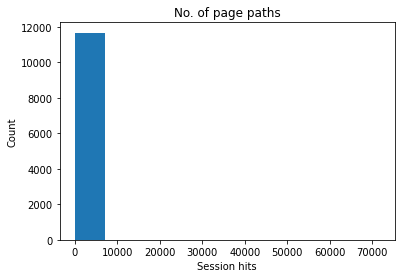

In [348]:
# plot distribution of session hit data 
x = [y['sessionHits'] for x, y in nodes_list]

plt.hist(x); # , bins = 10
plt.xlabel('Session hits')
plt.ylabel('Count')
plt.title('No. of page paths')

In [ ]:
# boxplot to identify outliers
plt.boxplot(x)

,0
count,11677.000000
mean,70.353515
std,1241.689420
min,1.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,71667.000000


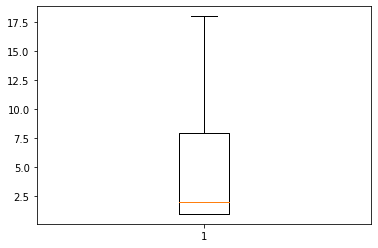

In [349]:
# descriptives, and remove outliers in boxplot
plt.boxplot(x, showfliers=False)
pd.DataFrame(x).describe()

In [ ]:
# look at distribution of session hit data up to 100
x = [y['sessionHits'] for x, y in nodes_list]
x=sorted(x, reverse=True)
x=x[2:]
plt.hist(x,bins=10,range=(0,100))
plt.xlabel('Session hits')
plt.ylabel('Count')
plt.title('No. of session hits')
plt.show()

## Improving the precision of the subgraph

The recall of the subgraph (11677 nodes) is acceptable. However, we need to improve the precision (i.e. reduce the number of nodes) so that a human can manually trawl through the list of pages, and not be overwhelmed. 

- Remove **irrelevant pages**. There are a number of pages that have high session hit data and are not relevant to the WUJ. These should be predefined and removed. While some would be relevant to remove in all graphs (e.g. `/search/all`), other pages are more unique, but patterns emerge. For example, pages related to `pensions` and `criminal convinctions`. 

- Remove **session hits equal to or lower than 20**. We assume these pages are irrelevant. 

- Remove pages where **shortest page path length from is equal to or greater than 3, from both seed0 pages**

- Remove pages where the **accumulated edge weight for one page is equal to or greater than 20**

This leaves us with a subgraph of: 
- 1384 nodes
- 37/41 nodes in the subgraph, which are also in the manually defined list of pages

### Remove irrelevant pages 

In [347]:
# order pages in descending order related to session hits
sorted(g.nodes(data=True), key=lambda x: x[1]['sessionHits'], reverse=True)

[('/find-a-job', {'sessionHits': 71667}),
 ('/prove-right-to-work', {'sessionHits': 68277}),
 ('/apply-apprenticeship', {'sessionHits': 52112}),
 ('/', {'sessionHits': 42271}),
 ('/request-copy-criminal-record', {'sessionHits': 29136}),
 ('/search/all', {'sessionHits': 20003}),
 ('/contact-jobcentre-plus', {'sessionHits': 19282}),
 ('/browse/working/state-pension', {'sessionHits': 18091}),
 ('/jobseekers-allowance', {'sessionHits': 16855}),
 ('/browse/working', {'sessionHits': 16320}),
 ('/view-prove-immigration-status', {'sessionHits': 13253}),
 ('/view-right-to-work', {'sessionHits': 9942}),
 ('/check-state-pension', {'sessionHits': 9251}),
 ('/jobseekers-allowance/eligibility', {'sessionHits': 8482}),
 ('/check-state-pension/sign-in/prove-identity', {'sessionHits': 8222}),
 ('/sign-in-universal-credit', {'sessionHits': 7623}),
 ('/topic/further-education-skills/apprenticeships', {'sessionHits': 7488}),
 ('/browse/working/finding-job', {'sessionHits': 6709}),
 ('/jobseekers-allowance

In [ ]:
# remove nodes 
g.remove_nodes_from(['/prove-right-to-work', '/', '/request-copy-criminal-record', '/browse/working/state-pension', 
                     '/search/all','/search', '/brexit', '/coronavirus', '/report-covid19-result'])

### Remove pages with session hits equal or lower than 20


Decide a cut-off to remove pages with sessions hits lower than X. 20 seems to contain still a good number of pre-defined pages (38/41), and reduces the number of nodse in the graph drastically (11677 > 1703).  
- Equal or lower than 10: 2450 nodes, 39/41, [`/find-driving-instructor-training`, `/guidance/international-trade-products-and-schemes`]
- Equal or lower than 20: 1703 nodes, 38/41, [`/guidance/recovery-loan-scheme`, `/find-driving-instructor-training`, `/guidance/international-trade-products-and-schemes`]
- Equal or lower than 30: 1355 nodes, 35/41, [`/guidance/recovery-loan-scheme`, `/find-driving-instructor-training`,
 `/education`, `/guidance/international-trade-products-and-schemes`, `/agricultural-skills-and-training`, `/government/collections/financial-support-for-businesses-during-coronavirus-covid-19`]

In [ ]:
# frequency table for session hits
x = sorted([y['sessionHits'] for x, y in nodes_list], reverse=True)
Counter(x)

#### Equal to or lower than 10 sessions

In [ ]:
# pages with less than 10 session hits 
remove = [node for node, session in g.nodes(data=True) if session['sessionHits'] <= 10]

# remove nodes with less than 10 session hits 
g.remove_nodes_from(remove)

# how many nodes and edges
nx.info(g)

In [ ]:
# how many of the start a business pages in the functional graph?
getNoOfTruePages(g)

In [ ]:
# which pages are in the economic recovery list but not in the subgraph list? 
getPagesNotInSubGraph(g)

#### Equal to or lower than 20 sessions

In [ ]:
# pages with less than 20 session hits 
remove = [node for node, session in g.nodes(data=True) if session['sessionHits'] <= 20]

# remove nodes with less than 20 session hits 
g.remove_nodes_from(remove)

# how many nodes and edges
nx.info(g)

In [ ]:
# how many of the economic recovery pages in the functional graph?
getNoOfTruePages(g)

In [ ]:
# which pages are in the economic recovery list but not in the subgraph list? 
getPagesNotInSubGraph(g)

#### Equal to or lower than 30 sessions

In [ ]:
# pages with less than 30 session hits 
remove = [node for node, session in g.nodes(data=True) if session['sessionHits'] <= 30]

# remove nodes with less than 30 session hits 
g.remove_nodes_from(remove)

# how many nodes and edges
nx.info(g)

In [ ]:
# how many of the start a business pages in the functional graph?
getNoOfTruePages(g)

In [ ]:
# which pages are in the economic recovery list but not in the subgraph list? 
getPagesNotInSubGraph(g)

### Remove pages with max shortest page paths from `seed0` pages >= 3

Identify the shortest page paths from seed0 pages to all other pages. 

Frequency distribution of shortest page path lengths: 
- `seed0.1`; /browse/working/finding-job; {3: 72, 2: 1484, 1: 146, 0: 1}
- `seed0.2`: /topic/further-education-skills/apprenticeships; {3: 173, 2: 1419, 1: 110, 0: 1}


If the shortest page path is equal to or greater than 3, remove from the nodes from the subgraph:
- 1688 nodes
- 38/41 
- Pages in the manually defined list not in the subgraph: ['/guidance/recovery-loan-scheme', '/find-driving-instructor-training', '/guidance/international-trade-products-and-schemes']

In [ ]:
# sort nodes by closeness to seed 0 pages
shortest_paths_seed0_1 = nx.shortest_path_length(g, source='/browse/working/finding-job')
shortest_paths_seed0_2 = nx.shortest_path_length(g, source='/topic/further-education-skills/apprenticeships')

In [ ]:
# sort nodes in descending order
finding_job={k: v for k, v in sorted(shortest_paths_seed0_1.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
# sort nodes in descending order
apprentice={k: v for k, v in sorted(shortest_paths_seed0_2.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
# frequency table for `seed0.1`
x = sorted([y for x, y in finding_job.items()], reverse=True)
Counter(x)

In [ ]:
# frequency table for `seed0.2`
x = sorted([y for x, y in apprentice.items()], reverse=True)
Counter(x)

In [ ]:
# extract list of pages that have a shortest page path length of >= 3
finding_job_filtered=[node for node, length in finding_job.items() if length >= 3]
apprentice_filtered=[node for node, length in apprentice.items() if length >= 3]

# extract list of page where they have a shortest page path length on >= 3 from both `seed0` pages
remove=[node for node in finding_job_filtered if node not in apprentice_filtered]

# remove list of pages from g
g.remove_nodes_from(remove)

# number of nodes and esges
nx.info(g)

In [ ]:
# how many of the economic recovery pages in the functional graph?
getNoOfTruePages(g)

In [ ]:
# which pages are in the economic recovery list but not in the subgraph list? 
getPagesNotInSubGraph(g)

#### Exploration: remove pages with the shortest page paths summed (`seed0.1` + `seed0.2`)

Could also look at the sum of the shortest page paths. However, the caveat here is that if the shortest page path length is `1` from `seed0.1` to `page A`, but `6` from `seed0.2` to `page A`, then the sum would be `7`. However, `page A` may be very relevant to the WUJ, as defined by it's shortest page path length from `seed0.1`.  

Therefore, this method has not been chosen. 

In [ ]:
# sum all pages shortest page paths of both `seed0` nodes to get an overall shortest page path proxy metric
combined_paths = []

for page, closeness in finding_job.items():
    for page1, closeness1 in apprentice.items():
        if page == page1: 
            combined_score = closeness + closeness1
            combined_paths.append(page)
            combined_paths.append(combined_score)
            
combined_paths=dict(zip(combined_paths[::2], combined_paths[1::2]))
combined_paths={k: v for k, v in sorted(combined_paths.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
# remove nodes above or equal to 6 paths away  
remove=[node for node, length in combined_paths.items() if length >= 6]
g.remove_nodes_from(remove)

In [ ]:
# how many of economic recovery pages are in the functional graph?
getNoOfTruePages(g)

In [ ]:
# which pages are in the economic recovery list but not in the subgraph list? 
getPagesNotInSubGraph(g)

### Remove pages where edge weight is <= 20


Edge weight increases by 1 each time a user session visits page A to page B. Therefore, if edge weight is small, we assume the two pages are likely to not be associated with one another. This is because we assume that user's will visit similar pages in the same WUJ during the same session. 

Edge weight is equal to or less than 10:
- 1615 nodes
- 38/41 
- Pages not in the subgraph list: ['/guidance/recovery-loan-scheme', 
'/find-driving-instructor-training', 
'/guidance/international-trade-products-and-schemes']

Edge weight is equal to or less than 20:
- 1384 nodes
- 37/41 
- Pages not in the subgraph list: ['/guidance/recovery-loan-scheme',
 '/find-driving-instructor-training',
 '/guidance/international-trade-products-and-schemes',
 '/agricultural-skills-and-training']

Edge weight is equal to or less than 30:
- 1151 nodes
- 34/41 
- Pages not in the subgraph list: ['/guidance/recovery-loan-scheme',
 '/find-driving-instructor-training',
 '/education',
 '/guidance/plan-for-jobs-skills-and-employment-programmes-information-for-employers',
 '/guidance/international-trade-products-and-schemes',
 '/agricultural-skills-and-training',
 '/government/collections/financial-support-for-businesses-during-coronavirus-covid-19']

In [ ]:
# weight (user movement) for each pair of nodes in the graph  
user_movement_weights = []
for node1, node2, edgeWeight in g.edges(data=True):
    case = {'node1': node1, 'node2': node2, 'edgeWeight':edgeWeight['edgeWeight']}
    user_movement_weights.append(case)

#sorted(user_movement_weights, key=itemgetter('edgeWeight'), reverse=True)

# sum the weight for each node 
user_movements_sum = defaultdict(float)

for info in user_movement_weights:
    user_movements_sum[info['node1']] += info['edgeWeight']

user_movements_sum = [{'node1': node1, 'edgeWeight': user_movements_sum[node1]} 
                     for node1 in user_movements_sum]

#sorted(user_movements_sum, key=lambda x: x['edgeWeight'], reverse=False)

In [ ]:
# frequency table for user_movements_sum >> TO DO AND SORT OUT
x = sorted([y['sessionHits'] for x, y in nodes_list], reverse=True)
Counter(x)

#### Remove pages where edge weight is less than or equal to 10 

In [ ]:
# remove anything with edge weight less than 10 
remove=[node['node1'] for node in user_movements_sum if node['edgeWeight'] <= 10]
g.remove_nodes_from(remove)

# number of nodes and esges
nx.info(g)

In [ ]:
# how many of economic recovery pages are in the functional graph?
getNoOfTruePages(g)

In [ ]:
# which pages are in the economic recovery list but not in the subgraph list? 
getPagesNotInSubGraph(g)

#### Remove pages where edge weight is less than or equal to 20 

In [ ]:
# remove anything with edge weight less than 20 
remove=[node['node1'] for node in user_movements_sum if node['edgeWeight'] <= 20]
g.remove_nodes_from(remove)

# number of nodes and esges
nx.info(g)

In [ ]:
# how many of economic recovery pages are in the functional graph?
getNoOfTruePages(g)

In [ ]:
# which pages are in the economic recovery list but not in the subgraph list? 
getPagesNotInSubGraph(g)

#### Remove pages where edge weight is less than or equal to 30 

In [ ]:
# remove anything with edge weight less than 30 
remove=[node['node1'] for node in user_movements_sum if node['edgeWeight'] <= 30]
g.remove_nodes_from(remove)

# number of nodes and esges
nx.info(g)

In [ ]:
# how many of economic recovery pages are in the functional graph?
getNoOfTruePages(g)

In [ ]:
# which pages are in the economic recovery list but not in the subgraph list? 
getPagesNotInSubGraph(g)

### Save the subgraph list of pages that are related to the economic recovery whole user journey

From the above exploration, run this code to get a final subgraph related to the economic recovery whole user journey

In [9]:
# import the NetworkX graph object
g = nx.read_gpickle("../../data/processed/functional_session_hit_directed_graph_er.gpickle")

In [10]:
# remove irrelevant nodes 
g.remove_nodes_from(['/prove-right-to-work', '/', '/request-copy-criminal-record', '/browse/working/state-pension', 
                     '/search/all','/search', '/brexit', '/coronavirus', '/report-covid19-result'])

In [11]:
# remove pages with less than 20 session hits 
remove = [node for node, session in g.nodes(data=True) if session['sessionHits'] <= 20]
g.remove_nodes_from(remove)

In [12]:
# remove pages where they have a shortest page path length on >= 3 from both `seed0` pages
shortest_paths_seed0_1 = nx.shortest_path_length(g, source='/browse/working/finding-job')
shortest_paths_seed0_2 = nx.shortest_path_length(g, source='/topic/further-education-skills/apprenticeships')

finding_job={k: v for k, v in sorted(shortest_paths_seed0_1.items(), key=lambda item: item[1], reverse=True)}
apprentice={k: v for k, v in sorted(shortest_paths_seed0_2.items(), key=lambda item: item[1], reverse=True)}

finding_job_filtered=[node for node, length in finding_job.items() if length >= 3]
apprentice_filtered=[node for node, length in apprentice.items() if length >= 3]

remove=[node for node in finding_job_filtered if node not in apprentice_filtered]
g.remove_nodes_from(remove)

In [13]:
# remove pages where accumulated edge weight is equal to or lower than 20
user_movement_weights = []
for node1, node2, edgeWeight in g.edges(data=True):
    case = {'node1': node1, 'node2': node2, 'edgeWeight':edgeWeight['edgeWeight']}
    user_movement_weights.append(case)

user_movements_sum = defaultdict(float)

for info in user_movement_weights:
    user_movements_sum[info['node1']] += info['edgeWeight']

user_movements_sum = [{'node1': node1, 'edgeWeight': user_movements_sum[node1]} 
                     for node1 in user_movements_sum]

remove=[node['node1'] for node in user_movements_sum if node['edgeWeight'] <= 20]
g.remove_nodes_from(remove)

In [14]:
nx.info(g)

'DiGraph with 1378 nodes and 37027 edges'

In [354]:
# how many of economic recovery pages are in the functional graph?
getNoOfTruePages(g)

37

In [355]:
# which pages are in the economic recovery list but not in the subgraph list? 
getPagesNotInSubGraph(g)

['/guidance/recovery-loan-scheme',
 '/find-driving-instructor-training',
 '/guidance/international-trade-products-and-schemes',
 '/agricultural-skills-and-training']

In [17]:
# final subgraph list related to the economic recovery whole user journey
economic_recovery_subgraph = list(g.nodes(data=True))
economic_recovery_subgraph

[('/view-prove-immigration-status', {'sessionHits': 13253}),
 ('/browse/working', {'sessionHits': 16320}),
 ('/find-a-job', {'sessionHits': 71667}),
 ('/check-state-pension', {'sessionHits': 9251}),
 ('/check-state-pension/sign-in/prove-identity', {'sessionHits': 8222}),
 ('/jobseekers-allowance', {'sessionHits': 16855}),
 ('/jobseekers-allowance/eligibility', {'sessionHits': 8482}),
 ('/view-right-to-work', {'sessionHits': 9942}),
 ('/contact-jobcentre-plus', {'sessionHits': 19282}),
 ('/government/organisations/disclosure-and-barring-service',
  {'sessionHits': 6095}),
 ('/topic/further-education-skills/apprenticeships', {'sessionHits': 7488}),
 ('/apply-apprenticeship', {'sessionHits': 52112}),
 ('/browse/working/finding-job', {'sessionHits': 6709}),
 ('/jobseekers-allowance/apply-new-style-jsa', {'sessionHits': 6578}),
 ('/browse/employing-people', {'sessionHits': 6476}),
 ('/dbs-update-service', {'sessionHits': 4002}),
 ('/criminal-record-checks-apply-role', {'sessionHits': 5176})

## Ranking the subgraph

We now have a subgraph of 1384 nodes. How do we rank these pages so that the most 'relevant' pages to a WUJ are at the top, while the most 'irrelevant' pages to a WUJ are at the bottom? 

### Order by session hits

In [18]:
sessions = list(sorted(economic_recovery_subgraph, key=lambda x: x[1]['sessionHits'], reverse=True))

### Order by shortest page path lengths

In [19]:
# calculate the paths of the shortest page path
shortest_paths_seed0 = nx.shortest_path_length(g, source='/browse/working/finding-job')
shortest_paths_seed1 = nx.shortest_path_length(g, source='/topic/further-education-skills/apprenticeships')

In [20]:
# seeed0.1: shortest_paths_seed0: '/browse/working/finding-job'
shortest_seed0_1 = {k: v for k, v in sorted(shortest_paths_seed0.items(), key=lambda item: item[1], reverse=False)}

In [21]:
# seed0.2: shortest_paths_seed1: '/topic/further-education-skills/apprenticeships'
shortest_seed0_2 = {k: v for k, v in sorted(shortest_paths_seed1.items(), key=lambda item: item[1], reverse=False)}

### Order by the sum of the shortest page path lengths

In [22]:
combined_paths = []

for page, closeness in finding_job.items():
    for page1, closeness1 in apprentice.items():
        if page == page1: 
            combined_score = closeness + closeness1
            combined_paths.append(page)
            combined_paths.append(combined_score)
            
combined_paths=dict(zip(combined_paths[::2], combined_paths[1::2]))
combined_paths={k: v for k, v in sorted(combined_paths.items(), key=lambda item: item[1], reverse=True)}
combined_paths

{'/government/publications/lrs-help-and-support/lrs-help-and-support': 8,
 '/government/publications/lrs-maintenance-schedule': 7,
 '/funeral-payments/eligibility': 7,
 '/guidance/veterans-uk-armed-forces-pensions-forms': 7,
 '/government/publications/filtering-rules-for-criminal-record-check-certificates/filtering-rules-for-dbs-certificates-criminal-record-checks': 7,
 '/government/publications/dbs-certificate-disputes-and-fingerprint-consent-forms-and-guidance-af14-af15/dbs-certificate-disputes-and-fingerprint-consent-guidance': 7,
 '/get-help-savings-low-income/eligibility': 6,
 '/child-benefit/make-a-change-to-your-claim': 6,
 '/government/publications/social-security-abroad-ni38': 6,
 '/plan-retirement-income/pensions-from-the-government': 6,
 '/register-for-self-assessment/not-self-employed': 6,
 '/dismiss-staff/how-to-dismiss-someone': 6,
 '/council-housing/types-of-tenancy': 6,
 '/staff-redundant/compulsory-redundancy': 6,
 '/paye-for-employers/keeping-records': 6,
 '/get-help-

### Order by centrality metrics

In [23]:
# between centrality: the number of shortest paths that pass through the node - a 'bridge' between nodes
g_di = nx.DiGraph(g)
g_di_between = nx.betweenness_centrality(g_di)
g_between = dict(sorted(g_di_between.items(), key=operator.itemgetter(1),reverse=True))
g_between

{'/browse/working': 0.12712311180181318,
 '/browse/employing-people': 0.11018235716020713,
 '/find-a-job': 0.09155815650182145,
 '/contact-jobcentre-plus': 0.06741718291768693,
 '/apply-apprenticeship': 0.044261243720232345,
 '/jobseekers-allowance': 0.044007477804340014,
 '/browse/benefits': 0.04392593448266593,
 '/view-prove-immigration-status': 0.029138967511996326,
 '/sign-in-universal-credit': 0.023528647122390188,
 '/government/organisations/department-for-work-pensions': 0.019904786990316885,
 '/log-in-register-hmrc-online-services': 0.019787095197816386,
 '/browse/tax': 0.01781441454627203,
 '/browse/visas-immigration': 0.017706443845333673,
 '/search/services': 0.016827421231071258,
 '/state-pension-age': 0.015611621183797808,
 '/benefits-calculators': 0.015095620176340651,
 '/universal-credit': 0.014594114584187967,
 '/access-to-work': 0.014488443335791138,
 '/national-minimum-wage-rates': 0.013846223794754047,
 '/browse/working/finding-job': 0.012276946978413413,
 '/browse/w

In [24]:
# degree centrality: counts the number of incoming and outgoing relationships from a node - 'most connected'
g_degree = nx.degree_centrality(g)
g_degree = dict(sorted(g_degree.items(), key=operator.itemgetter(1),reverse=True))
g_degree

{'/browse/working': 0.6978939724037764,
 '/find-a-job': 0.6005809731299927,
 '/browse/employing-people': 0.5824255628177197,
 '/contact-jobcentre-plus': 0.5359477124183006,
 '/jobseekers-allowance': 0.46332607116920843,
 '/browse/benefits': 0.46042120551924476,
 '/apply-apprenticeship': 0.38852578068264343,
 '/sign-in-universal-credit': 0.3289760348583878,
 '/government/organisations/department-for-work-pensions': 0.3064633260711692,
 '/view-prove-immigration-status': 0.3042846768336964,
 '/log-in-register-hmrc-online-services': 0.2766884531590414,
 '/benefits-calculators': 0.27233115468409586,
 '/browse/tax': 0.2694262890341322,
 '/universal-credit': 0.2679738562091503,
 '/browse/visas-immigration': 0.2679738562091503,
 '/state-pension-age': 0.23965141612200436,
 '/browse/disabilities': 0.2280319535221496,
 '/access-to-work': 0.2178649237472767,
 '/search/services': 0.2120551924473493,
 '/browse/education': 0.20043572984749455,
 '/national-minimum-wage-rates': 0.20043572984749455,
 '/

In [25]:
# closeness centrality: average length of the shortest path between the node and all other nodes in the graph
g_closeness = nx.closeness_centrality(g)
g_closeness = dict(sorted(g_closeness.items(), key=operator.itemgetter(1),reverse=True))
g_closeness

{'/browse/working': 0.6553864281298438,
 '/browse/employing-people': 0.5999130568134435,
 '/browse/benefits': 0.5843606996244847,
 '/contact-jobcentre-plus': 0.5833689971219399,
 '/find-a-job': 0.5823806548989464,
 '/jobseekers-allowance': 0.5748330795219115,
 '/apply-apprenticeship': 0.5471550840495076,
 '/browse/tax': 0.5454187727950863,
 '/browse/visas-immigration': 0.5439085151172518,
 '/government/organisations/department-for-work-pensions': 0.5413388685891387,
 '/view-prove-immigration-status': 0.538371466803607,
 '/universal-credit': 0.537319549127164,
 '/sign-in-universal-credit': 0.5339808645500631,
 '/browse/disabilities': 0.5325332014780838,
 '/log-in-register-hmrc-online-services': 0.5280340730477775,
 '/government/organisations': 0.5260140498150009,
 '/browse/education': 0.5240094231007669,
 '/browse/births-deaths-marriages': 0.5238098004633952,
 '/browse/citizenship': 0.5226152513175266,
 '/search/services': 0.5222182780920671,
 '/government/organisations/hm-revenue-custo

### Overall rank from multiple ranked items (above)

In [26]:
# create lists in order
sessions_list=[(index, element[0]) for index, element in enumerate(sessions)]
shortest_seed0_1_list=[(index, element) for index, element in enumerate(shortest_seed0_1)]
shortest_seed0_2_list=[(index, element) for index, element in enumerate(shortest_seed0_2)]
combined_paths_list=[(index, element) for index, element in enumerate(combined_paths)]
g_between_list=[(index, element) for index, element in enumerate(g_between)]
g_degree_list=[(index, element) for index, element in enumerate(g_degree)]
g_closeness_list=[(index, element) for index, element in enumerate(g_closeness)]

In [ ]:
ranking_number = {}

for index, page in sessions_list: 
    for index1, page1 in shortest_seed0_1_list:
        for index2, page2 in shortest_seed0_2_list:
            for index3, page3 in g_closeness_list:
                if page == page1 == page2 == page3:
                    ranking_number[page]=index+index1+index2+index3
                            
final_list={k: v for k, v in sorted(ranking_number.items(), key=lambda item: item[1], reverse=True)}


In [28]:
ranking_number = {}

for index, page in sessions_list: 
    for index1, page1 in shortest_seed0_1_list:
        for index2, page2 in shortest_seed0_2_list:
            for index3, page3 in combined_paths_list:
                for index4, page4 in g_between_list:
                    for index5, page5 in g_degree_list:
                        for index6, page6 in g_closeness_list:
                            if page == page1 == page2 == page3 == page4 == page5 == page6:
                                ranking_number[page]=index+index1+index2+index3+index4+index5+index6
                            
{k: v for k, v in sorted(ranking_number.items(), key=lambda item: item[1], reverse=True)}

[(0, '/find-a-job'),
 (1, '/apply-apprenticeship'),
 (2, '/contact-jobcentre-plus'),
 (3, '/jobseekers-allowance'),
 (4, '/browse/working'),
 (5, '/view-prove-immigration-status'),
 (6, '/view-right-to-work'),
 (7, '/check-state-pension'),
 (8, '/jobseekers-allowance/eligibility'),
 (9, '/check-state-pension/sign-in/prove-identity'),
 (10, '/sign-in-universal-credit'),
 (11, '/topic/further-education-skills/apprenticeships'),
 (12, '/browse/working/finding-job'),
 (13, '/jobseekers-allowance/apply-new-style-jsa'),
 (14, '/browse/employing-people'),
 (15, '/government/organisations/disclosure-and-barring-service'),
 (16, '/become-apprentice'),
 (17, '/criminal-record-checks-apply-role'),
 (18, '/access-to-work'),
 (19, '/browse/benefits'),
 (20, '/government/organisations/department-for-work-pensions'),
 (21, '/check-job-applicant-right-to-work'),
 (22, '/state-pension-age'),
 (23, '/universal-credit'),
 (24, '/new-state-pension'),
 (25, '/dbs-update-service'),
 (26, '/contact-pension-s

In [345]:
# unweighted average
ranking_number = {}

for index, page in sessions_list: 
    for index1, page1 in shortest_seed0_1_list:
        for index2, page2 in shortest_seed0_2_list:
            for index3, page3 in combined_paths_list:
                for index4, page4 in g_between_list:
                    for index5, page5 in g_degree_list:
                        for index6, page6 in g_closeness_list:
                            if page == page1 == page2 == page3 == page4 == page5 == page6:
                                ranking_number[page]=index+index1+index2+index3+index4+index5+index6
                            
{k: v for k, v in sorted(ranking_number.items(), key=lambda item: item[1], reverse=True)}

KeyboardInterrupt: 